# Introduction to Process Mining with PM4PY
Code is partially copied from this tutorial: https://medium.com/@c3_62722/process-mining-with-python-tutorial-a-healthcare-application-part-1-ae02027a050

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
fn = 'ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()


,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [4]:
print('{} has {} rows and {} columns.'.format(fn, events.shape[0], events.shape[1]))


ArtificialPatientTreatment.csv has 690 rows and 4 columns.


In [5]:
## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='patient')
events['relativetime'] = events['datetime'] - events['casestart']
events['caselength'] = events['caseend'] - events['casestart']
events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,6 days 20:49:17


In [6]:
events['action'] = events['action'].apply(lambda x: x.strip())

# Descriptive Statistics

### How many events per case?

Text(0, 0.5, 'Number of patients')

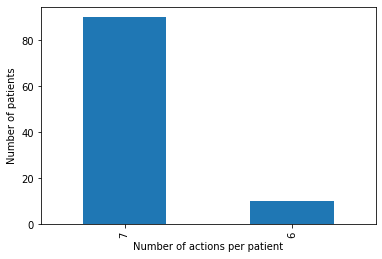

In [7]:
events['patient'].value_counts().value_counts().plot(kind='bar')
plt.xlabel('Number of actions per patient')
plt.ylabel('Number of patients')

### Action occurrences

Text(0, 0.5, 'number of occurrences')

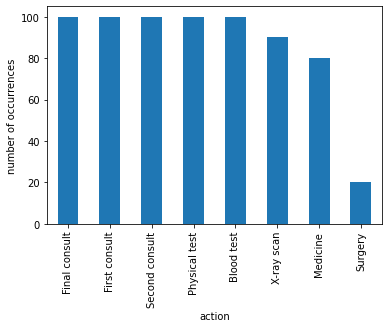

In [8]:
events['action'].value_counts().plot(kind='bar')
plt.xlabel('action')
plt.ylabel('number of occurrences')

### Scatterplot of sequences
relative time: Time since start of case

In [9]:
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
ordered = events.sort_values(by=['caselength', 'patient', 'relativetime_s'])

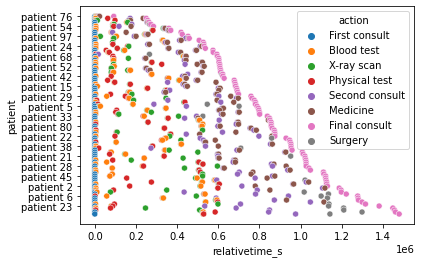

In [10]:
## Time in seconds
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered['action'])
plt.yticks(np.arange(0, 100, 5));
plt.show()


# Process Mining

In [11]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [12]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)


### Footprint Analysis

In [13]:
# footprint analysis
fp_log = footprints_discovery.apply(eventlog, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

### Occurences of binary relations

In [14]:
fp_log['dfg']

Counter({('First consult', 'Blood test'): 40,
         ('Blood test', 'Physical test'): 35,
         ('Physical test', 'Second consult'): 36,
         ('Second consult', 'Surgery'): 20,
         ('Surgery', 'Final consult'): 20,
         ('First consult', 'Physical test'): 33,
         ('Physical test', 'Blood test'): 33,
         ('Blood test', 'X-ray scan'): 32,
         ('X-ray scan', 'Second consult'): 31,
         ('Second consult', 'Medicine'): 80,
         ('Medicine', 'Final consult'): 80,
         ('Physical test', 'X-ray scan'): 31,
         ('X-ray scan', 'Blood test'): 27,
         ('Blood test', 'Second consult'): 33,
         ('X-ray scan', 'Physical test'): 32,
         ('First consult', 'X-ray scan'): 27})

### Causalities

In [15]:
fp_log['sequence']

{('Blood test', 'Second consult'),
 ('First consult', 'Blood test'),
 ('First consult', 'Physical test'),
 ('First consult', 'X-ray scan'),
 ('Medicine', 'Final consult'),
 ('Physical test', 'Second consult'),
 ('Second consult', 'Medicine'),
 ('Second consult', 'Surgery'),
 ('Surgery', 'Final consult'),
 ('X-ray scan', 'Second consult')}

### Parallel

In [16]:
fp_log['parallel']

{('Blood test', 'Physical test'),
 ('Blood test', 'X-ray scan'),
 ('Physical test', 'Blood test'),
 ('Physical test', 'X-ray scan'),
 ('X-ray scan', 'Blood test'),
 ('X-ray scan', 'Physical test')}

## Footprint table

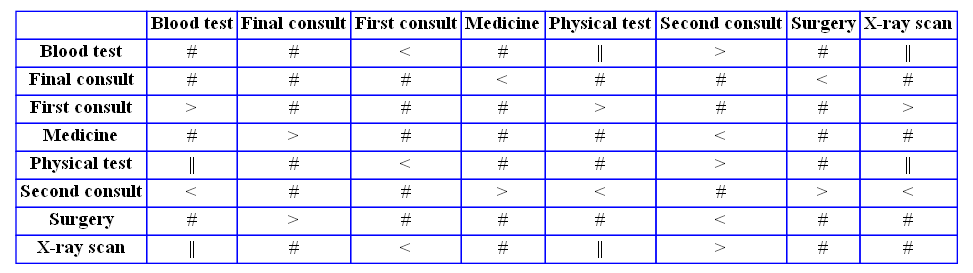

In [17]:
from pm4py.visualization.footprints import visualizer as fp_visualizer
gviz = fp_visualizer.apply(fp_log)
fp_visualizer.view(gviz)

### Directly-follows graph

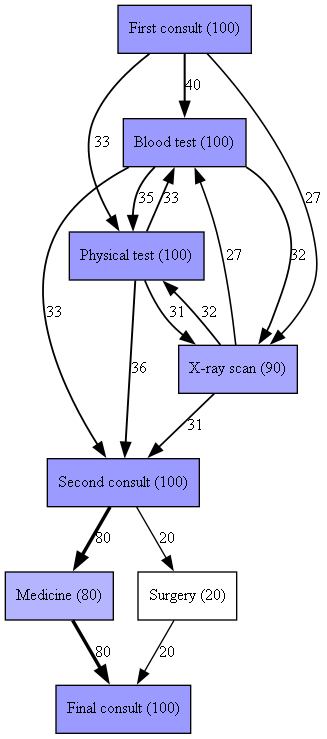

In [18]:
#Create graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

### Alpha miner

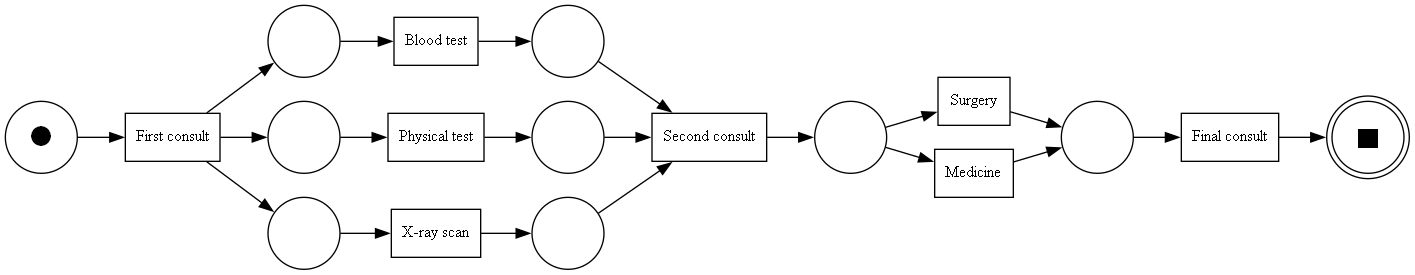

In [19]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants :: 100%|██████████| 15/15 [00:00<00:00, 906.63it/s]


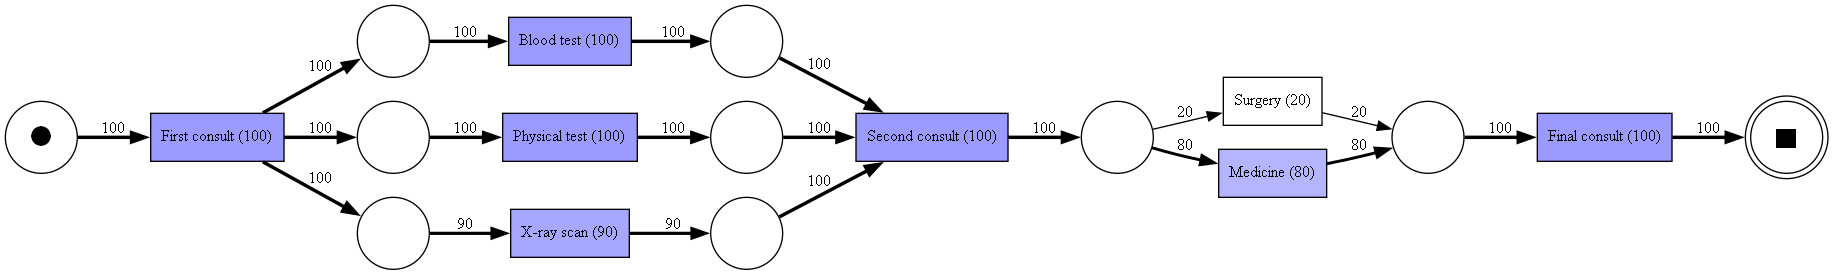

In [20]:
# add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz2 = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

pn_visualizer.view(gviz2)

### Reachability graph

In [21]:
from pm4py.objects.petri_net.utils import reachability_graph
ts = reachability_graph.construct_reachability_graph(net, initial_marking)
            

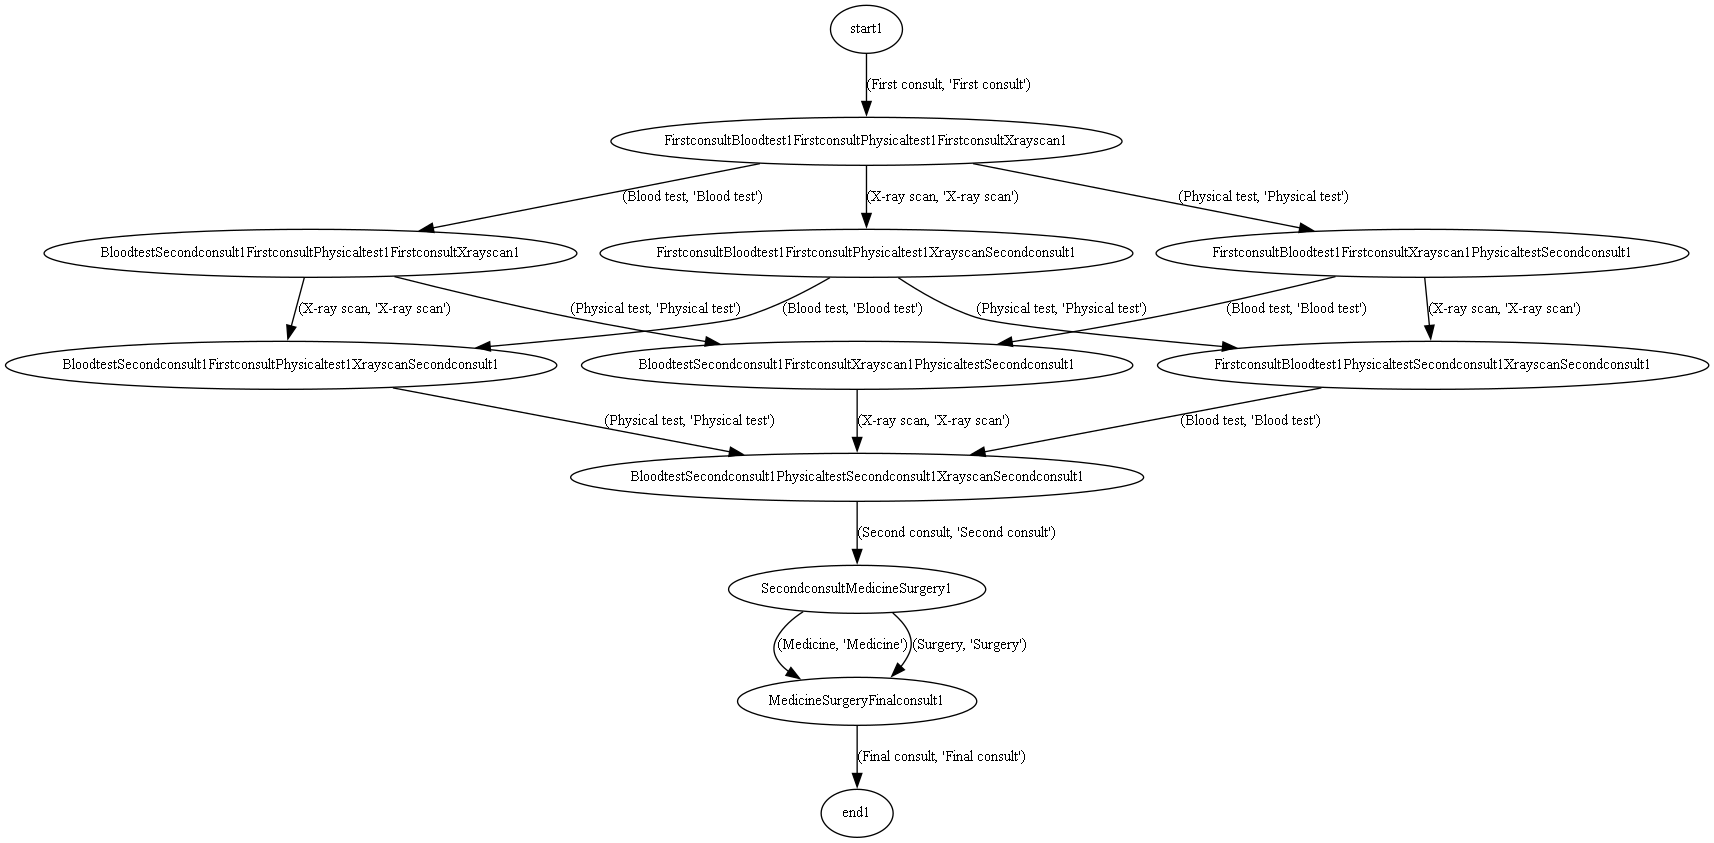

In [22]:
from pm4py.visualization.transition_system import visualizer as ts_visualizer
gviz3 = ts_visualizer.apply(ts)
ts_visualizer.view(gviz3)
                                